In [2]:
import praw
import csv

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Replace 'YOUR_CLIENT_ID', 'YOUR_CLIENT_SECRET', and 'YOUR_USER_AGENT' with your actual credentials
reddit = praw.Reddit(
    client_id='',
    client_secret='',
    user_agent=''
)


In [3]:
# Function to fetch posts from a subreddit
def fetch_posts(subreddit_name, limit=100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for submission in subreddit.hot(limit=limit):
        posts.append({
            'id': submission.id,
            'title': submission.title,
            'score': submission.score,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': submission.created,
            'body': submission.selftext
        })
    return posts

# Function to fetch comments for a given post ID
def fetch_comments(post_id):
    submission = reddit.submission(id=post_id)
    submission.comments.replace_more(limit=None)
    comments = []
    for comment in submission.comments.list():
        comments.append({
            'id': comment.id,
            'body': comment.body,
            'score': comment.score,
            'created': comment.created,
            'parent_id': comment.parent_id
        })
    return comments


In [35]:

subreddit = 'bittensor_'
posts = fetch_posts(subreddit, limit=1000)

# Save posts to a CSV file
with open(f'reddit/{subreddit}_post.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['id', 'title', 'score', 'url', 'num_comments', 'created', 'body']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for post in posts:
        writer.writerow(post)


print(f'{subreddit} data fetched')


bittensor_ data fetched


In [36]:
subreddit = 'FetchAI_Community'
posts = fetch_posts(subreddit, limit=1000)

# Save posts to a CSV file
with open(f'reddit/{subreddit}_post.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['id', 'title', 'score', 'url', 'num_comments', 'created', 'body']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for post in posts:
        writer.writerow(post)

print(f'{subreddit} data fetched')


FetchAI_Community data fetched


In [37]:
subreddits_projects = ['oceanprotocol', 'SingularityNet']


for subreddit in subreddits_projects:
    # fetch subreddit posts and comments
    posts = fetch_posts(subreddit, limit=1000)

    # Save posts to a CSV file
    with open(f'reddit/{subreddit}_post.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['id', 'title', 'score', 'url', 'num_comments', 'created', 'body']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for post in posts:
            writer.writerow(post)

    print(f'{subreddit} data fetched')

oceanprotocol data fetched
SingularityNet data fetched


In [94]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]

media_tokens = ['TAO', 'FET', 'OCEAN', 'AGIX']

posts = ['bittensor__post.csv', 'FetchAI_Community_post.csv',
        'oceanprotocol_post.csv', 'SingularityNet_post.csv']


In [95]:
def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'


def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'price/{price_files[idx]}'
    return pd.read_csv(filename)

def get_reddit_data(token, tokens_list, post_files):
    idx = tokens_list.index(token)
    filename = f'reddit/{post_files[idx]}'
    return pd.read_csv(filename)



In [96]:
def clean_price_data(price_df):

    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day
    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def get_commit_trends(commits_df):
    flat_commit = pd.json_normalize(commits_df['commit'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df.drop(columns=['commit'], inplace=True)

    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date

    date_counts = pd.DataFrame()

    date_counts['commit_count'] = commits_df['author.date'].value_counts()

    
    # Reset index to make the date a column
    date_counts = date_counts.reset_index()
    date_counts.columns = ['date', 'commit_count']

    # Convert 'date' column to datetime
    date_counts['date'] = pd.to_datetime(date_counts['date'])
    date_counts['year'] = pd.to_datetime(date_counts['date']).dt.year

    # Set 'date' column as the index
    date_counts.set_index('date', inplace=True)

    # Resample into daily intervals and fill missing dates with zeros
    daily_counts = date_counts.asfreq('D', fill_value=0)

    # Resample into monthly and quarterly intervals
    yearly_counts = date_counts.resample('Y').agg({'commit_count': 'sum', 'year': 'first'})
    monthly_counts = date_counts.resample('M').agg({'commit_count': 'sum', 'year': 'first'})
    weekly_counts = date_counts.resample('W').agg({'commit_count': 'sum', 'year': 'first'})

    return daily_counts, yearly_counts, monthly_counts, weekly_counts

In [97]:
def merging_df(price_df, trend_df, time_frame):
    #Resample data into Weekly data from daily
    temporal_price = price_df.set_index('Date')

    temporal_df = temporal_price.resample(time_frame).agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    temporal_df.reset_index(inplace=True)

    trend_df.reset_index(inplace=True)
    
    # Set the timeframe for merging
    point0 = trend_df['date'][0]

    price_trend = temporal_df[temporal_df['Date']>=point0]
    price_trend.reset_index(inplace=True, drop=True)

    

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='date')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year', 'Month', 'commit_count']]
    return price_trend

In [98]:
def correlations(df, token, ax=None):
    correlations = df.corr()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax, cmap="mako")
    ax.set_title(f'Correlations for {token}')
    fig.tight_layout()
    return ax

In [106]:

def clean_reddit_data(post_df):
    # Convert the 'created' column to datetime and extract the date
    post_df['created'] = pd.to_datetime(post_df['created'], unit='s').dt.date
    post_df['year'] = pd.to_datetime(post_df['created']).dt.year

    # Group by 'created' and aggregate
    post_df_grouped = post_df.groupby('created').agg({
        'score': 'sum',
        'num_comments': 'sum',
        'year': 'last'
    })

    # Add a count variable to know how many posts per date
    post_df_grouped['count'] = post_df.groupby('created').size()

    # Resample to ensure daily frequency, filling missing dates with zeros
    daily_posts = post_df_grouped.asfreq('D', fill_value=0)

    return daily_posts



In [107]:
def merge_reddit(price_trend, reddit, timeframe):
    reddit_resample = reddit.resample(timeframe).agg({'score': 'sum', 'num_comments': 'sum', 'count':'sum'})
    reddit_resample.reset_index(inplace=True)
    
    price_media = pd.merge(price_trend, reddit_resample, how='left', left_on='Date', right_on='created')

    return price_media

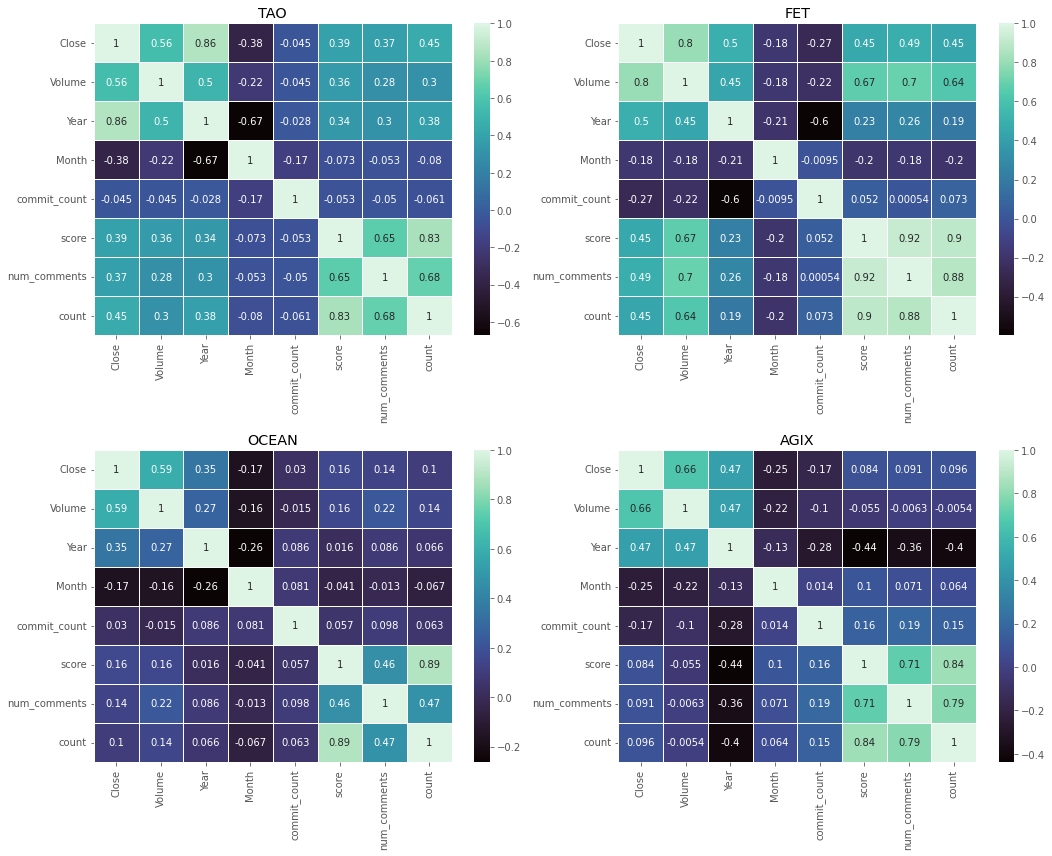

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Daily Correlations for commits

for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[0], 'D')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'D')
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
    correlations(price_media, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

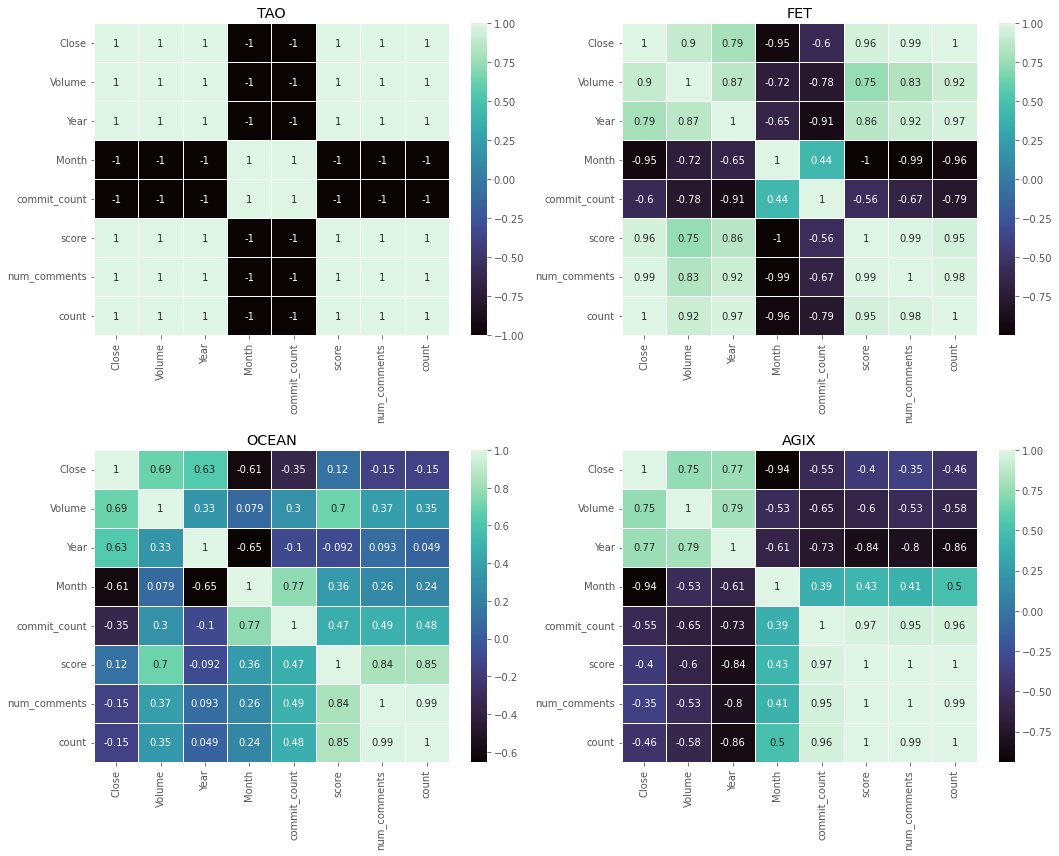

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Daily Correlations for commits

for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[1], 'Y')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'Y')
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
    correlations(price_media, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

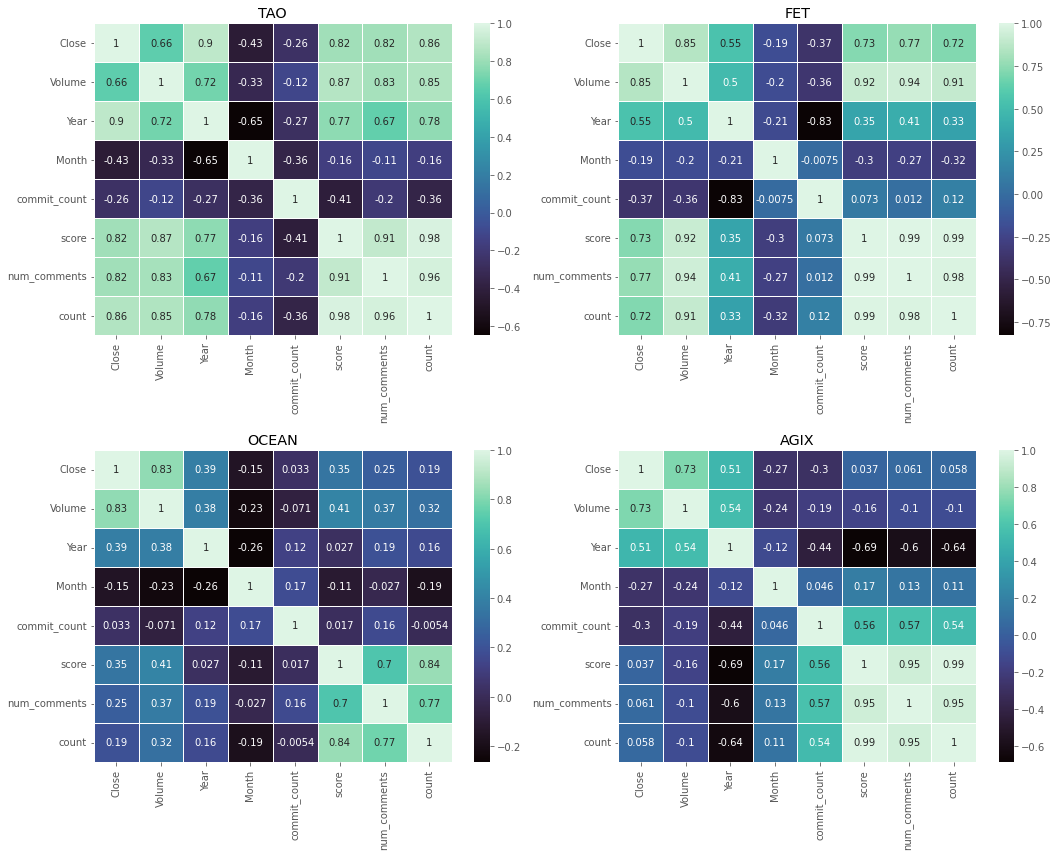

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Daily Correlations for commits

for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[2], 'M')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'M')
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
    correlations(price_media, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

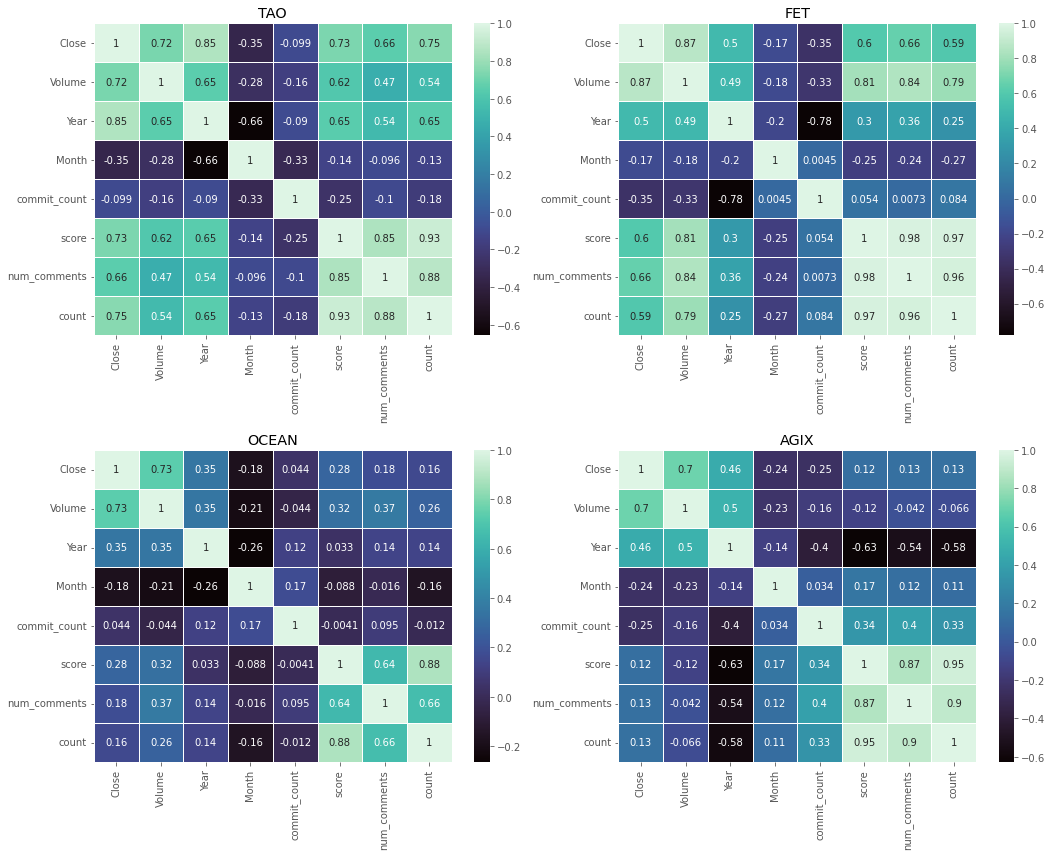

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Daily Correlations for commits

for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[3], 'W')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'W')
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
    correlations(price_media, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [122]:
def plot_data(merged_df, n_cols, token):

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30, 6))
    fig.tight_layout(pad=5.0)

    axes[0].plot(merged_df['Date'], merged_df['Close'])
    axes[1].plot(merged_df['Date'], np.log(merged_df['Volume']))
    axes[0].set(xlabel='Date', ylabel='Price (USD)', title=f'{token}-USD Chart')
    axes[1].set(xlabel='Date', ylabel='log(Volume)', title=f'{token}-USD Volume')

    if n_cols == 5:
        axes[2].plot(merged_df['Date'], merged_df['commit_count'])
        axes[2].set(xlabel='Date', ylabel='Commit Count', title=f"{token}'s gh Commits Trend")
        
        axes[3].plot(merged_df['Date'], merged_df['num_comments'])
        axes[3].set(xlabel='Date', ylabel='Comments', title=f"{token}'s Reddit Comments Trend")

        axes[4].plot(merged_df['Date'], merged_df['count'])
        axes[4].set(xlabel='Date', ylabel='Posts', title=f"{token}'s Reddit Posts Trend")

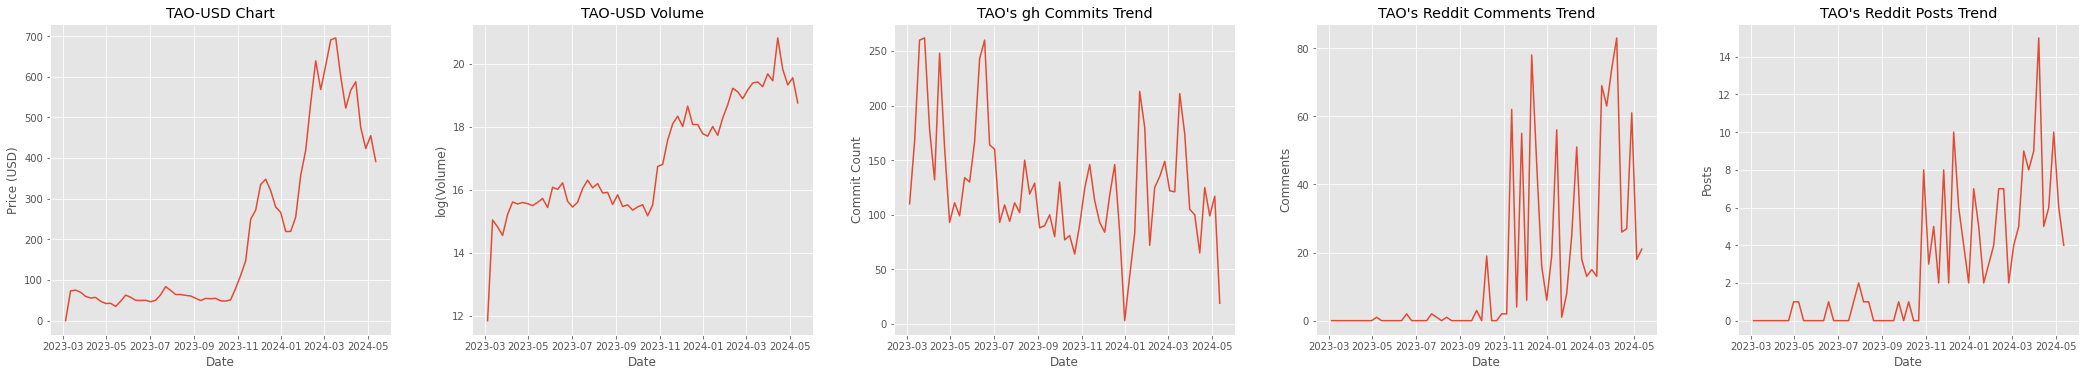

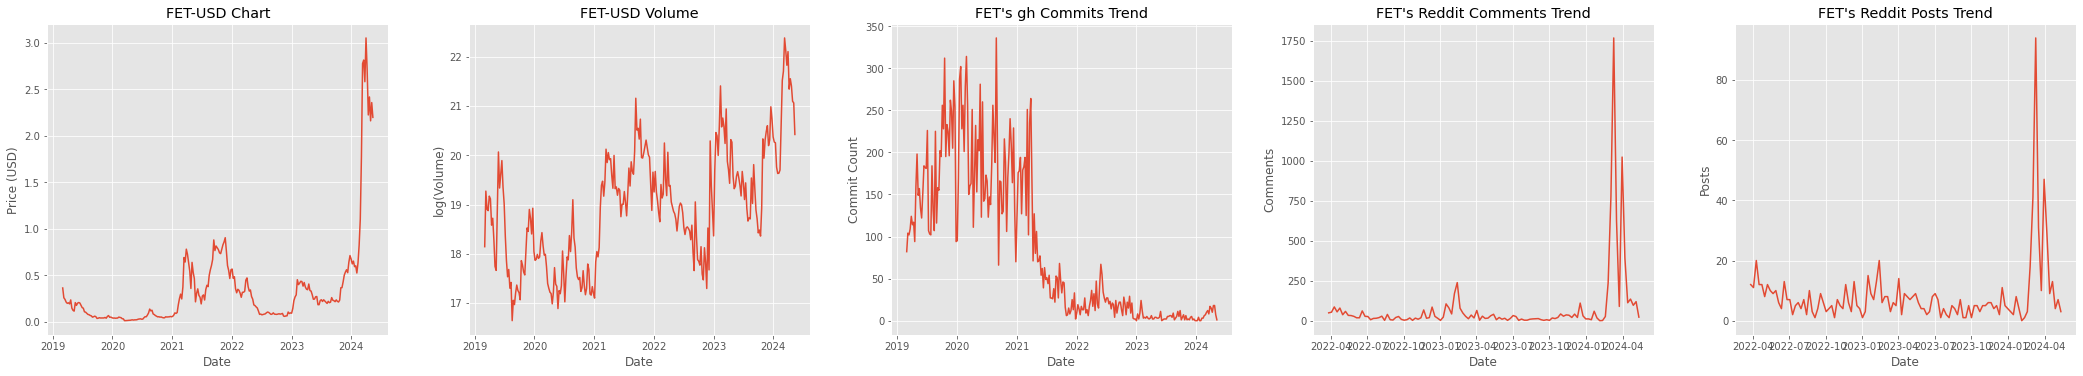

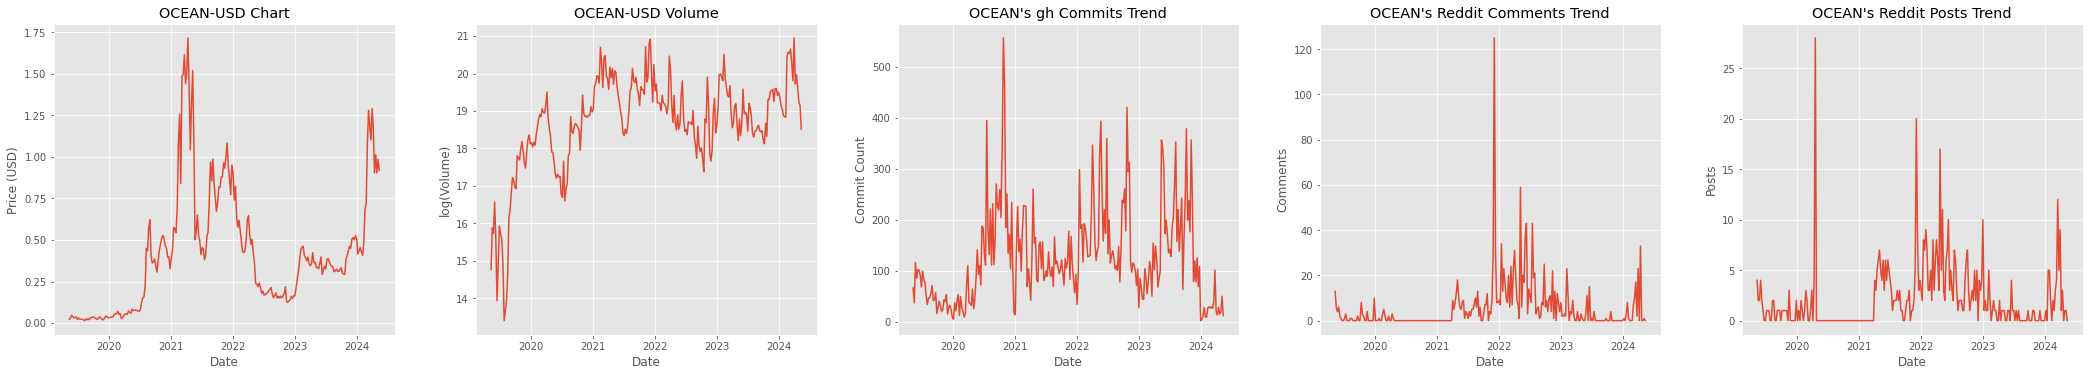

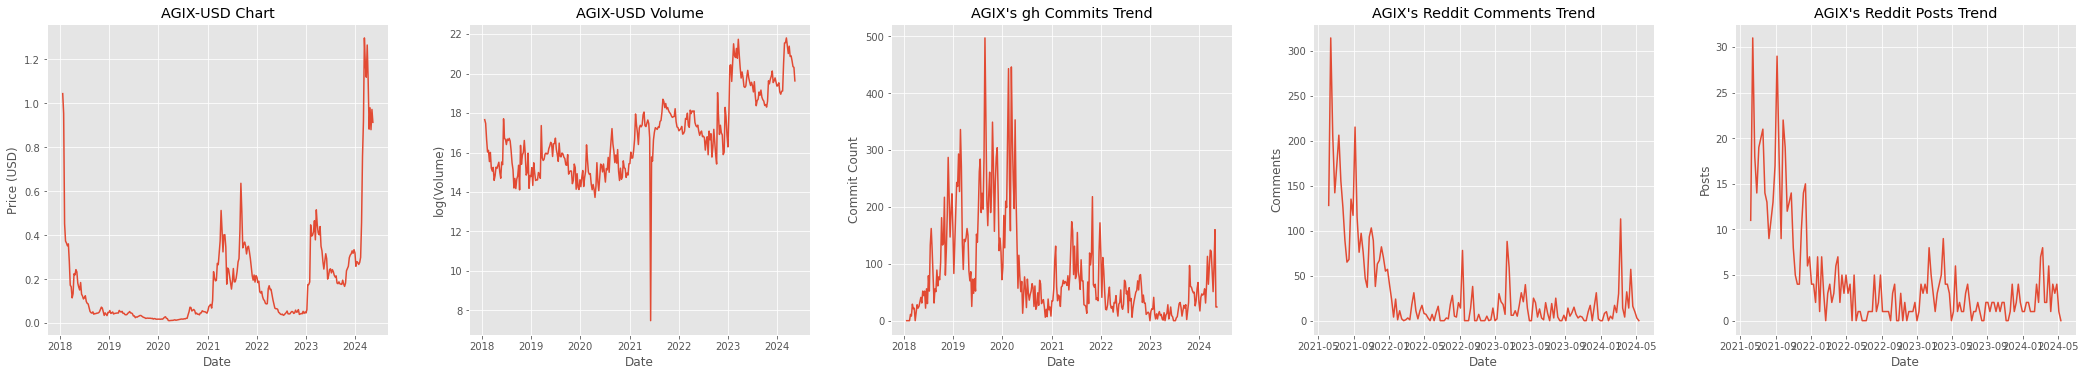

In [123]:
for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[3], 'W')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'W')
    plot_data(price_media, 5, token)

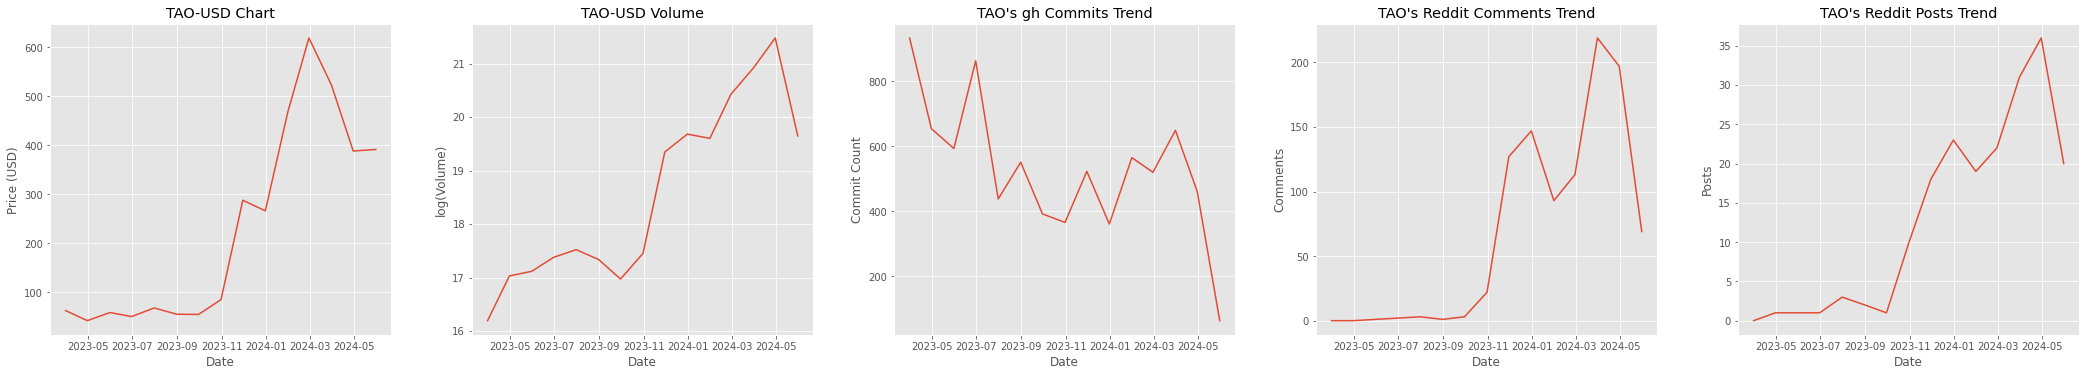

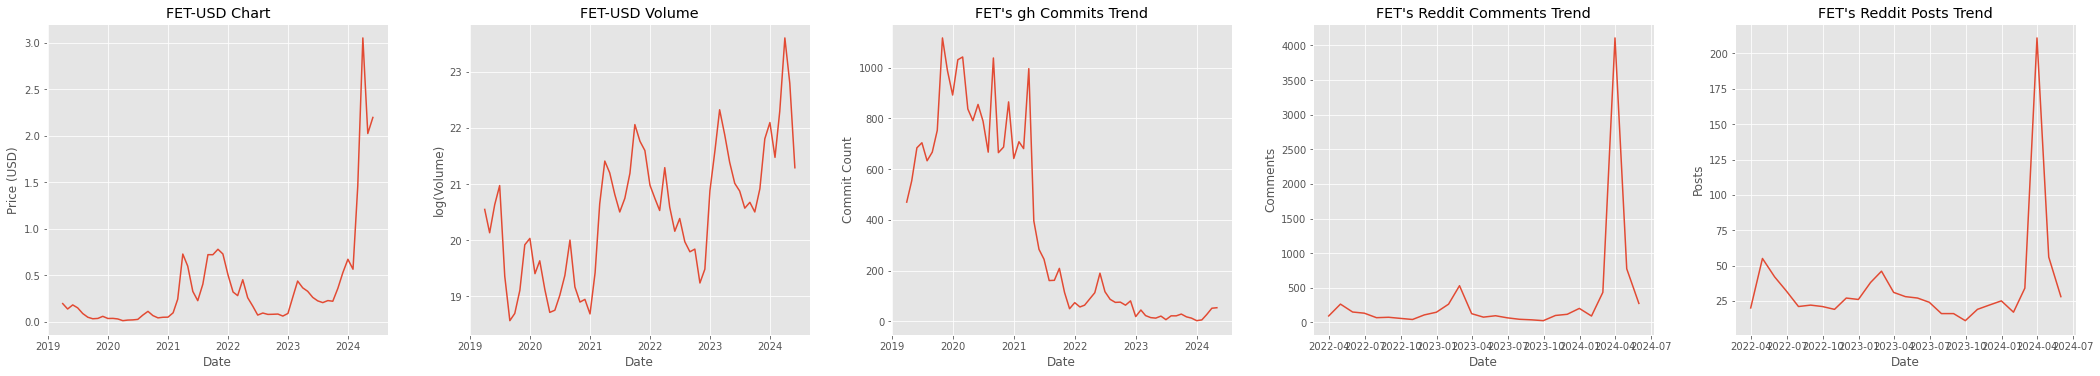

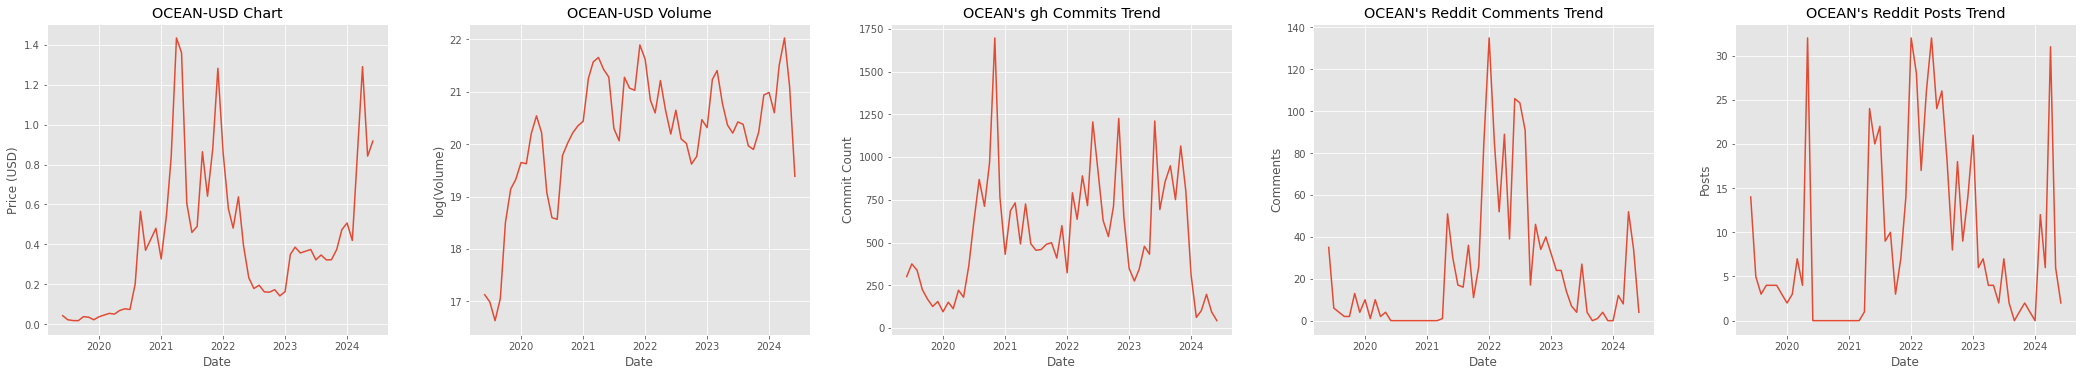

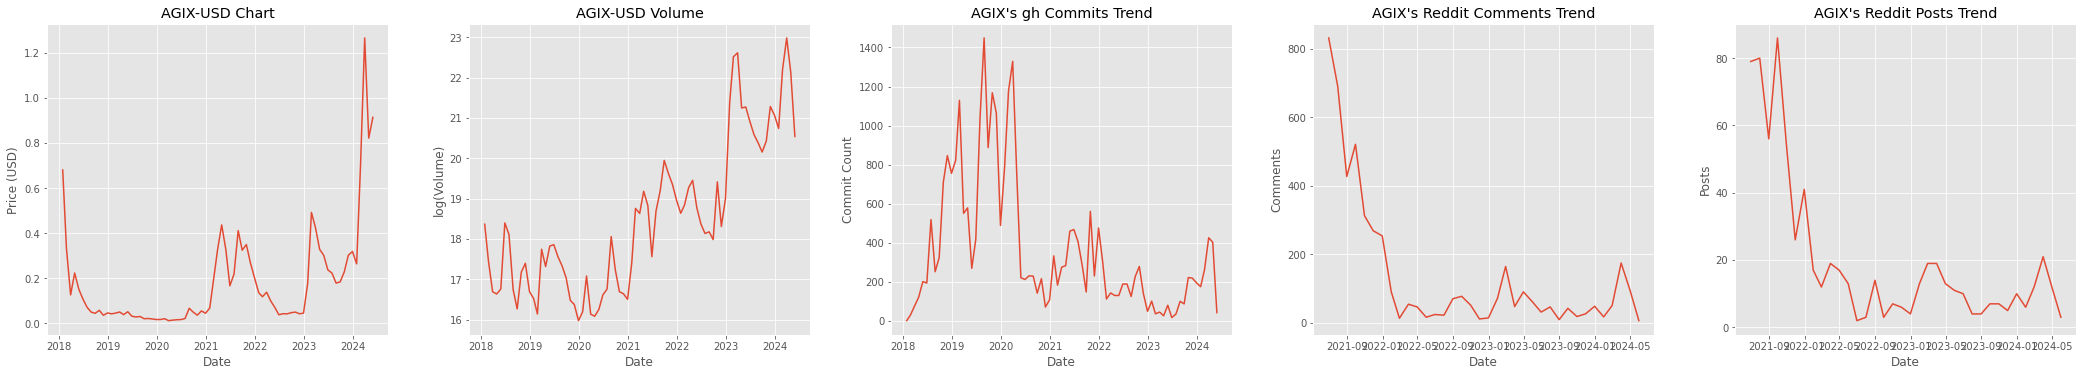

In [124]:
for i, token in enumerate(media_tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[2], 'M')
    reddit_posts = get_reddit_data(token, media_tokens, posts)
    clean_posts = clean_reddit_data(reddit_posts)
    price_media = merge_reddit(price_trend_df, clean_posts, 'M')
    plot_data(price_media, 5, token)